In [1]:
# Load python modules
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Resizing, Rescaling
import seaborn as sn
import tensorflow_datasets as tfds
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from tqdm import tqdm  # Perform iterature with progress bar
import numpy as np
import cv2
import os

In [2]:
#Class labelsb
class_names = ['Glass', 'Metal', 'Paper', 'Textile']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (64, 64)

In [3]:
print('Number of classes:', nb_classes)

Number of classes: 4


In [4]:
resize_layer_32 = tf.keras.Sequential([
    Resizing(32, 32),
])

In [5]:
def load_data():
    """
        Load the data from local folder
        
    """
    datasets = ['C:/Mani/Dataset/dataset1/train_ds',
               'C:/Mani/Dataset/dataset1/test_ds']
        
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
#Prepare dataset for training and testing
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading C:/Mani/Dataset/dataset1/train_ds


100%|███████████████████████████████████████████████████████████████████████████████| 270/270 [00:01<00:00, 195.35it/s]


Loading C:/Mani/Dataset/dataset1/test_ds


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 194.46it/s]


In [7]:
#Check the training and testing image shape
train_images.shape, test_images.shape

((1080, 64, 64, 3), (200, 64, 64, 3))

In [8]:
# Shuffle only the training dataset
np.random.seed(321)
train_images, train_labels = shuffle(train_images, train_labels)
test_images, test_labels = shuffle(test_images, test_labels)

In [9]:
#Check the number of training dataset
print('No of training images:', train_images.shape[0])

No of training images: 1080


In [10]:
#Normalise train and test image dataset from 0,255 to 0,1
train_images = train_images / 255.0 
test_images = test_images / 255.0

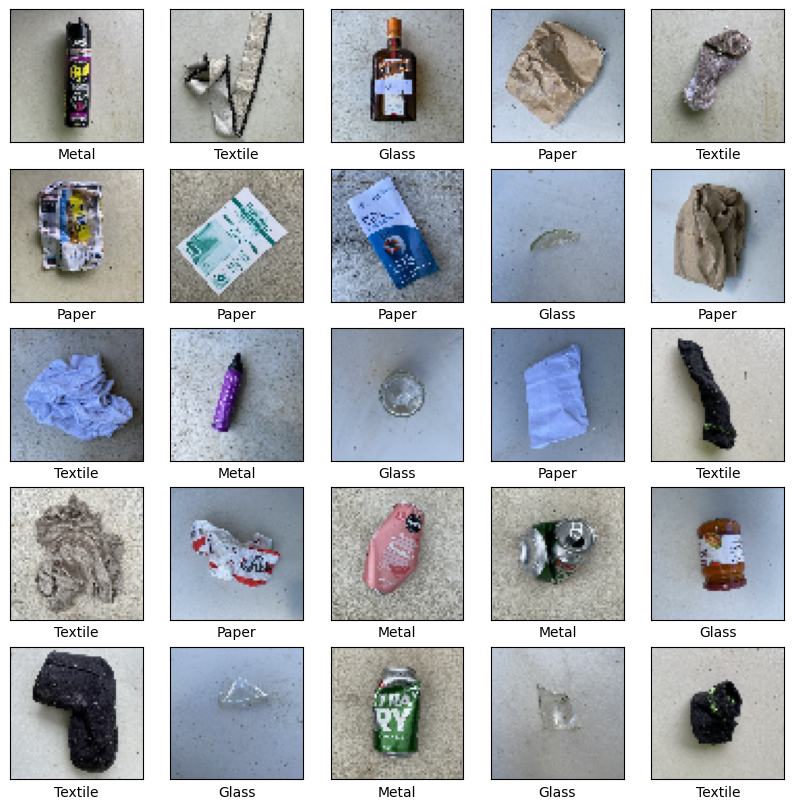

In [11]:
#Display 25 images 
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [12]:
#Sequential Model 1
# Experience 10 with Batch Normalisation
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,None,3)),
    resize_layer_32,
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')     
])

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,444 (1.61 MB)

 Trainable params: 421,444 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
#Sequential Model 2 
# With Batch Normalisation

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    #resize_layer_64,
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
       
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')   
])

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 298,756 (1.14 MB)

 Trainable params: 298,756 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
#Sequential Model 3 
# Model 3 with batch normalisation

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Input((64,64,3)),
    #resize_layer_64,
        
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')      
])

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 235,300 (919.14 KB)

 Trainable params: 235,300 (919.14 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Add callbacks to save the model weight with best accuracy during training
# import ModelCheckpoint package
# from tensorflow.keras.callbacks import ModelCheckpoint
# Source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath1 = 'C:/Mani/ModelCheckpoint/model1.keras'
model_checkpoint_callback1 = ModelCheckpoint(
    filepath=checkpoint_filepath1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


checkpoint_filepath2 = 'C:/Mani/ModelCheckpoint/model2.keras'
model_checkpoint_callback2 = ModelCheckpoint(
    filepath=checkpoint_filepath2,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

checkpoint_filepath3 = 'C:/Mani/ModelCheckpoint/model3.keras'
model_checkpoint_callback3 = ModelCheckpoint(
    filepath=checkpoint_filepath3,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [16]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy', 
                metrics=['accuracy'])


model_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])


model_3.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])
               

In [17]:
#Exponential decay for learning rate

def scheduler(epoch, lr):
    if epoch <= 20:
        return lr
    else:
        #return lr * tf.math.exp(-0.01)
        return lr * 0.90
        
    
lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [18]:
# Set number of epochs

epochs = 100
batch_size = 64


In [19]:

# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history1 = model_1.fit(train_images, train_labels,
                      batch_size=batch_size, epochs=epochs,
                      validation_split = 0.2, verbose=1,
                      callbacks=[model_checkpoint_callback1])


# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_1_training_time', end_time - start_time )


Time model start: 2024-11-08 11:53:09.927826
Epoch 1/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2269 - loss: 1.4272
Epoch 1: val_accuracy improved from -inf to 0.41204, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.2277 - loss: 1.4247 - val_accuracy: 0.4120 - val_loss: 1.3732
Epoch 2/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3716 - loss: 1.3486
Epoch 2: val_accuracy improved from 0.41204 to 0.42130, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3747 - loss: 1.3451 - val_accuracy: 0.4213 - val_loss: 1.2727
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4712 - loss: 1.2177
Epoch 3: val_accuracy improved from 0.42130 to 0.49074, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4718 - loss: 1.2137 - val_accuracy: 0.4907 - val_loss: 1.0946
Epoch 4/100
13/14 ━━━━━━━

Epoch 24/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8486 - loss: 0.4148
Epoch 24: val_accuracy did not improve from 0.71759
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8464 - loss: 0.4178 - val_accuracy: 0.7130 - val_loss: 0.7546
Epoch 25/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8288 - loss: 0.4471
Epoch 25: val_accuracy did not improve from 0.71759
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8276 - loss: 0.4474 - val_accuracy: 0.6944 - val_loss: 0.7522
Epoch 26/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8401 - loss: 0.4166
Epoch 26: val_accuracy improved from 0.71759 to 0.72222, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8399 - loss: 0.4167 - val_accuracy: 0.7222 - val_loss: 0.7095
Epoch 27/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8452 - loss: 0.3902
Epoch 27: val_accuracy did not improve from 0.72222
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/ste

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9648 - loss: 0.1370 - val_accuracy: 0.7361 - val_loss: 0.7736
Epoch 49/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9615 - loss: 0.1325
Epoch 49: val_accuracy did not improve from 0.75463
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9600 - loss: 0.1344 - val_accuracy: 0.7269 - val_loss: 0.7211
Epoch 50/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9587 - loss: 0.1322
Epoch 50: val_accuracy did not improve from 0.75463
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9588 - loss: 0.1321 - val_accuracy: 0.7222 - val_loss: 0.7720
Epoch 51/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9399 - loss: 0.1617
Epoch 51: val_accuracy did not improve from 0.75463
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9407 - loss: 0.1611 - val_accuracy: 0.7222 - val_loss: 0.8338
Epoch 52/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9608 - loss: 0.1346
Epoch 52: val_accuracy did not i

Epoch 74/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9830 - loss: 0.0710
Epoch 74: val_accuracy did not improve from 0.75463
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9829 - loss: 0.0698 - val_accuracy: 0.7315 - val_loss: 0.8314
Epoch 75/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9851 - loss: 0.0618
Epoch 75: val_accuracy did not improve from 0.75463
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9851 - loss: 0.0622 - val_accuracy: 0.7269 - val_loss: 0.9138
Epoch 76/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9825 - loss: 0.0582
Epoch 76: val_accuracy did not improve from 0.75463
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9819 - loss: 0.0590 - val_accuracy: 0.7407 - val_loss: 0.9833
Epoch 77/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9760 - loss: 0.0608
Epoch 77: val_accuracy did not improve from 0.75463
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9763 - loss: 0.0605 - val_accuracy: 0.7222

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9944 - loss: 0.0273
Epoch 99: val_accuracy improved from 0.75926 to 0.76389, saving model to C:/Mani/ModelCheckpoint/model1.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9942 - loss: 0.0270 - val_accuracy: 0.7639 - val_loss: 0.9977
Epoch 100/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9936 - loss: 0.0216
Epoch 100: val_accuracy did not improve from 0.76389
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9934 - loss: 0.0224 - val_accuracy: 0.7269 - val_loss: 1.0615
Time model end: 2024-11-08 11:54:01.123205
Model_1_training_time 0:00:51.195379


In [20]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)


history2 = model_2.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback2])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)

print('Model_2_training_time', end_time - start_time )

Time model start: 2024-11-08 11:54:01.131991
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3059 - loss: 1.3938
Epoch 1: val_accuracy improved from -inf to 0.30093, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.3049 - loss: 1.3936 - val_accuracy: 0.3009 - val_loss: 1.3787
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2592 - loss: 1.3803
Epoch 2: val_accuracy improved from 0.30093 to 0.42130, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.2604 - loss: 1.3792 - val_accuracy: 0.4213 - val_loss: 1.3383
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4241 - loss: 1.3067
Epoch 3: val_accuracy improved from 0.42130 to 0.49537, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.4263 - loss: 1.3041 - val_accuracy: 0.4954 - val_loss: 1.2165
Epoch 4/100
14/14 ━

Epoch 24/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8472 - loss: 0.4211
Epoch 24: val_accuracy did not improve from 0.72685
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8464 - loss: 0.4219 - val_accuracy: 0.7222 - val_loss: 0.6510
Epoch 25/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8540 - loss: 0.3989
Epoch 25: val_accuracy did not improve from 0.72685
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8540 - loss: 0.3988 - val_accuracy: 0.7176 - val_loss: 0.7066
Epoch 26/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8129 - loss: 0.4321
Epoch 26: val_accuracy improved from 0.72685 to 0.73148, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.8114 - loss: 0.4356 - val_accuracy: 0.7315 - val_loss: 0.6127
Epoch 27/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8266 - loss: 0.4236
Epoch 27: val_accuracy did not improve from 0.73148
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 1

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9429 - loss: 0.1389
Epoch 48: val_accuracy improved from 0.81481 to 0.81944, saving model to C:/Mani/ModelCheckpoint/model2.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9436 - loss: 0.1380 - val_accuracy: 0.8194 - val_loss: 0.5937
Epoch 49/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9557 - loss: 0.1087
Epoch 49: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9552 - loss: 0.1094 - val_accuracy: 0.8102 - val_loss: 0.5664
Epoch 50/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9582 - loss: 0.1220
Epoch 50: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9582 - loss: 0.1211 - val_accuracy: 0.7963 - val_loss: 0.6736
Epoch 51/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9524 - loss: 0.1243
Epoch 51: val_accuracy did not improve from 0.81944
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - a

Epoch 73/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9804 - loss: 0.0400
Epoch 73: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9807 - loss: 0.0398 - val_accuracy: 0.7870 - val_loss: 0.7385
Epoch 74/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9847 - loss: 0.0409
Epoch 74: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9850 - loss: 0.0404 - val_accuracy: 0.8194 - val_loss: 0.7682
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9814 - loss: 0.0584
Epoch 75: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9816 - loss: 0.0580 - val_accuracy: 0.7917 - val_loss: 0.7332
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9904 - loss: 0.0312
Epoch 76: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9903 - loss: 0.0315 - val_accuracy

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9913 - loss: 0.0307
Epoch 98: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9913 - loss: 0.0306 - val_accuracy: 0.8102 - val_loss: 0.8034
Epoch 99/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9864 - loss: 0.0345
Epoch 99: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9865 - loss: 0.0343 - val_accuracy: 0.8148 - val_loss: 0.8967
Epoch 100/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9865 - loss: 0.0427
Epoch 100: val_accuracy did not improve from 0.83333
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9866 - loss: 0.0426 - val_accuracy: 0.7917 - val_loss: 0.8678
Time model end: 2024-11-08 11:57:29.963580
Model_2_training_time 0:03:28.831589


In [21]:
# Register the model training start time.
start_time = datetime.now()
print('Time model start:', start_time)

history3 = model_3.fit(train_images, train_labels,
                       batch_size=batch_size, epochs= epochs, 
                       validation_split = 0.2, verbose=1,
                       callbacks=[model_checkpoint_callback3])

# Register the model training end time.
end_time = datetime.now()
print('Time model end:', end_time)
print('Model_3_training_time', end_time - start_time )


Time model start: 2024-11-08 11:57:29.971553
Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2662 - loss: 1.3971
Epoch 1: val_accuracy improved from -inf to 0.23148, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.2656 - loss: 1.3970 - val_accuracy: 0.2315 - val_loss: 1.3866
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.2653 - loss: 1.3843
Epoch 2: val_accuracy improved from 0.23148 to 0.23611, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.2661 - loss: 1.3843 - val_accuracy: 0.2361 - val_loss: 1.3838
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2692 - loss: 1.3806
Epoch 3: val_accuracy improved from 0.23611 to 0.24537, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.2700 - loss: 1.3804 - val_accuracy: 0.2454 - val_loss: 1.3662
Epoch 4/100
14/14 ━

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.7644 - loss: 0.5479 - val_accuracy: 0.7361 - val_loss: 0.6522
Epoch 24/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7660 - loss: 0.5715
Epoch 24: val_accuracy improved from 0.73611 to 0.74537, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.7656 - loss: 0.5717 - val_accuracy: 0.7454 - val_loss: 0.6775
Epoch 25/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.8052 - loss: 0.5015
Epoch 25: val_accuracy did not improve from 0.74537
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.8049 - loss: 0.5018 - val_accuracy: 0.7176 - val_loss: 0.6613
Epoch 26/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8254 - loss: 0.4571
Epoch 26: val_accuracy improved from 0.74537 to 0.76852, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.8254 - loss: 0.4579 - val_accuracy: 0.7685 - val_loss: 0.6

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9663 - loss: 0.1104
Epoch 48: val_accuracy did not improve from 0.80093
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9657 - loss: 0.1109 - val_accuracy: 0.7824 - val_loss: 0.7300
Epoch 49/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9404 - loss: 0.1396
Epoch 49: val_accuracy did not improve from 0.80093
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9399 - loss: 0.1406 - val_accuracy: 0.7870 - val_loss: 0.6183
Epoch 50/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9454 - loss: 0.1333
Epoch 50: val_accuracy improved from 0.80093 to 0.81019, saving model to C:/Mani/ModelCheckpoint/model3.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.9463 - loss: 0.1319 - val_accuracy: 0.8102 - val_loss: 0.6082
Epoch 51/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9698 - loss: 0.1068
Epoch 51: val_accuracy did not improve from 0.81019
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - a

Epoch 73/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9736 - loss: 0.0722
Epoch 73: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.9737 - loss: 0.0720 - val_accuracy: 0.7963 - val_loss: 0.6719
Epoch 74/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9766 - loss: 0.0596
Epoch 74: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.9768 - loss: 0.0594 - val_accuracy: 0.8056 - val_loss: 0.8021
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9849 - loss: 0.0604
Epoch 75: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9848 - loss: 0.0603 - val_accuracy: 0.7870 - val_loss: 0.7097
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9899 - loss: 0.0348
Epoch 76: val_accuracy did not improve from 0.82407
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9899 - loss: 0.0348 - val_accuracy

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9728 - loss: 0.0754
Epoch 98: val_accuracy did not improve from 0.82870
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.9729 - loss: 0.0754 - val_accuracy: 0.7269 - val_loss: 1.0362
Epoch 99/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9877 - loss: 0.0385
Epoch 99: val_accuracy did not improve from 0.82870
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.9876 - loss: 0.0385 - val_accuracy: 0.7963 - val_loss: 0.7717
Epoch 100/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9818 - loss: 0.0434
Epoch 100: val_accuracy did not improve from 0.82870
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.9820 - loss: 0.0432 - val_accuracy: 0.8056 - val_loss: 0.8971
Time model end: 2024-11-08 12:02:13.757521
Model_3_training_time 0:04:43.785968


Text(0.5, 1.0, 'Model 1 Accuracy (Exp:2.1)')

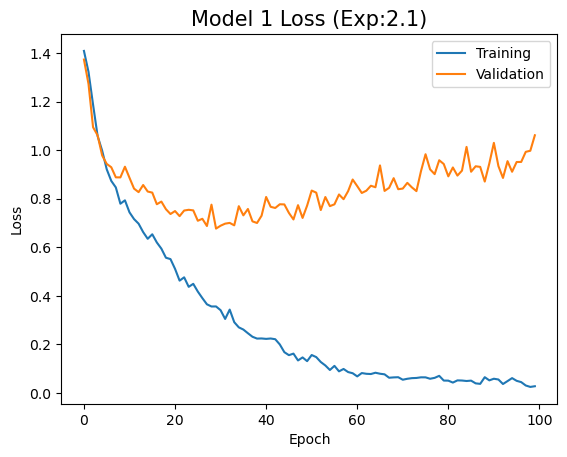

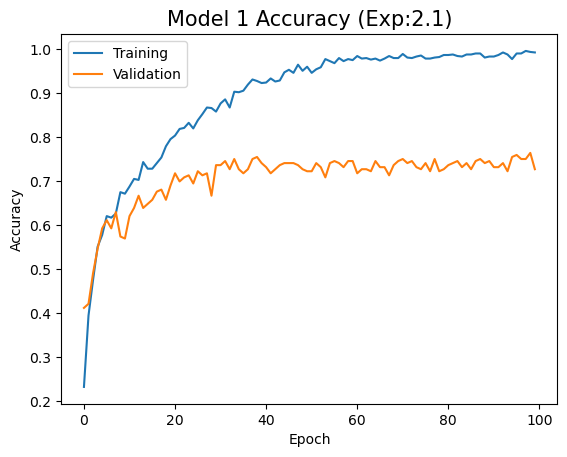

In [22]:

#Plot the training and validation loss
plt.figure()
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 1 Loss (Exp:2.1)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history1.history['accuracy'], label='Training')
plt.plot(history1.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.xlim(0.3, 1.0)
plt.title('Model 1 Accuracy (Exp:2.1)', fontsize = 15)


Text(0.5, 1.0, 'Model 2 Accuracy (Exp":2.1)')

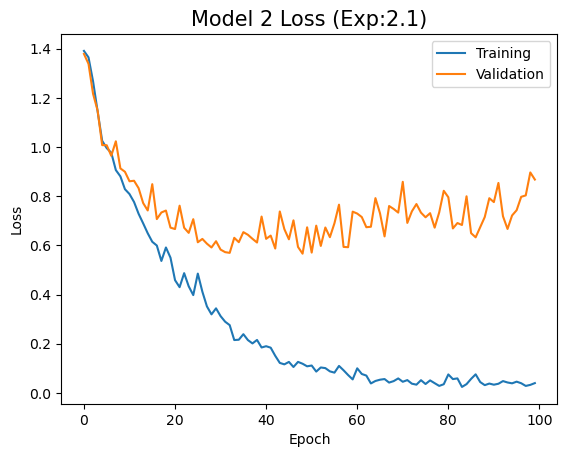

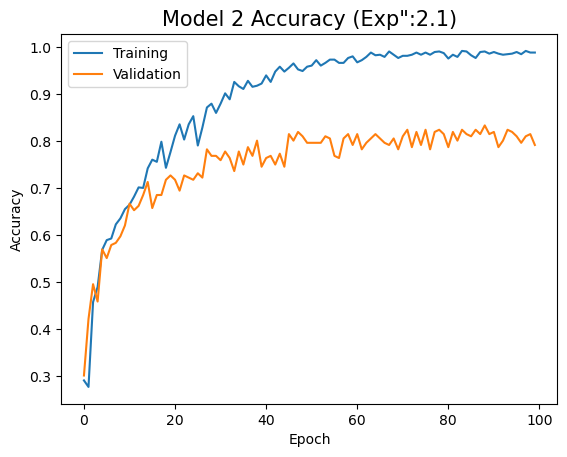

In [23]:
#Plot the training and validation loss
plt.figure()
plt.plot(history2.history['loss'], label='Training')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2 Loss (Exp:2.1)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history2.history['accuracy'], label='Training')
plt.plot(history2.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy (Exp":2.1)', fontsize = 15)

Text(0.5, 1.0, 'Model 3 Accuracy (Exp:2.1)')

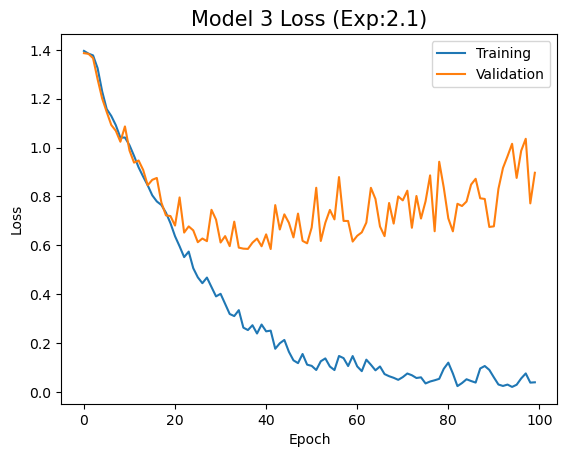

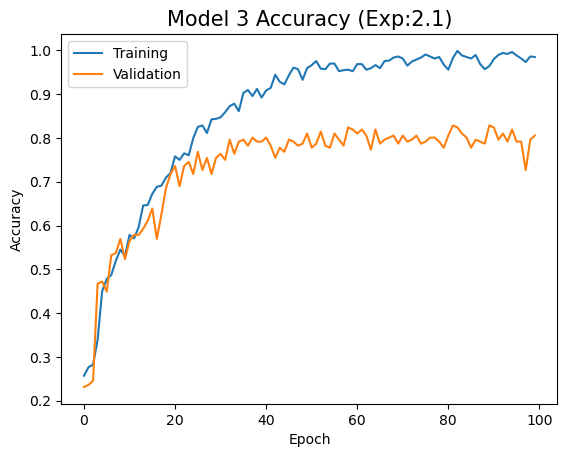

In [24]:
#Plot the training and validation loss
plt.figure()
plt.plot(history3.history['loss'], label='Training')
plt.plot(history3.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 3 Loss (Exp:2.1)', fontsize = 15)

#Plot the training and validation Accuracy
plt.figure()
plt.plot(history3.history['accuracy'], label='Training')
plt.plot(history3.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model 3 Accuracy (Exp:2.1)', fontsize = 15)

In [25]:
# Evaluate the test result for model 1, 2, 3
model_1.load_weights(checkpoint_filepath1)
Test_result1 = model_1.evaluate(test_images, test_labels, batch_size = 64)

model_2.load_weights(checkpoint_filepath2)
Test_result2 = model_2.evaluate(test_images, test_labels, batch_size = 64)

model_3.load_weights(checkpoint_filepath3)
Test_result3 = model_3.evaluate(test_images, test_labels, batch_size = 64)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8050 - loss: 0.8516
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8397 - loss: 0.6701
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8012 - loss: 0.7705


In [26]:
predictions1 = model_1.predict(test_images)     # Vector of probabilities
pred_label1 = np.argmax(predictions1, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [27]:
predictions = model_2.predict(test_images)     # Vector of probabilities
pred_label2 = np.argmax(predictions, axis = 1) # We take the highest probability


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [28]:
predictions3 = model_3.predict(test_images)     # Vector of probabilities
pred_label3 = np.argmax(predictions3, axis = 1) # We take the highest probability

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


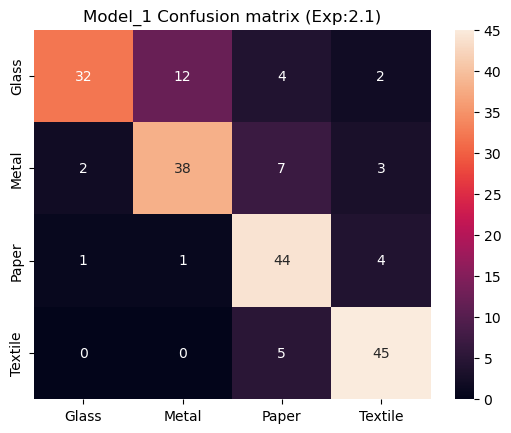

In [29]:
CM1 = confusion_matrix(test_labels, pred_label1)
ax = plt.axes()
sn.heatmap(CM1, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_1 Confusion matrix (Exp:2.1)')
plt.show()


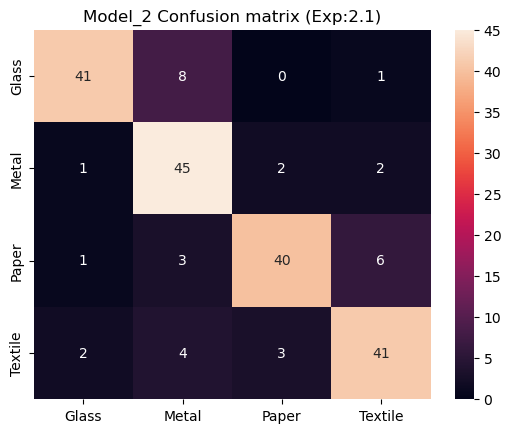

In [30]:
CM2 = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sn.heatmap(CM2, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_2 Confusion matrix (Exp:2.1)')
plt.show()



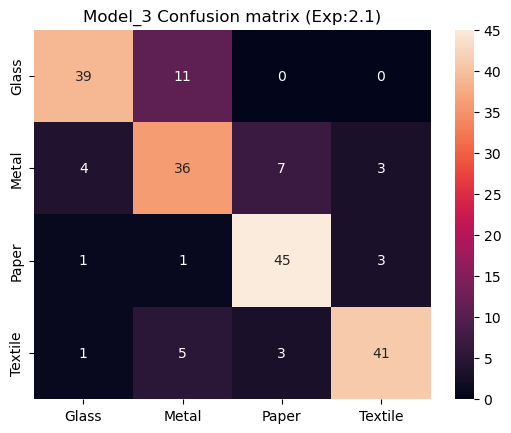

In [31]:
CM3 = confusion_matrix(test_labels, pred_label3)
ax = plt.axes()
sn.heatmap(CM3, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Model_3 Confusion matrix (Exp:2.1)')
plt.show()

